In [1]:
from libraries import lib
from libraries import utils
from libraries import tfim_functions
from libraries.NeuralStates import *
import qutip as qt
import torch.nn as nn 
import torch
import numpy as np
import matplotlib.pyplot as plt
import kan

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
N, J = 10, 1
num_epochs = 200
num_samples = 512
data_rate = 1
chains = 32

In [ ]:
# def generate_eloc_distr(sampled_vector, N, J, Gamma, model):
#     """
#     TODO
#     """
#     to_calculate = []
#     visited = {}
#     for basis_state in sampled_vector.distribution:
#         for adj in tfim_functions.generate_adjacencies(basis_state, N):
#             if adj not in sampled_vector.nn_output and adj not in visited:
#                 to_calculate.append(adj)
#                 visited[adj] = len(to_calculate) - 1
#     nn_output_calcs = model(utils.generate_input_samples(N, to_calculate)) if to_calculate else None

#     def model_to_output(x):
#         if x in sampled_vector.nn_output:
#             return torch.Tensor(sampled_vector.nn_output[x])
#         if x in visited:
#             return torch.Tensor(nn_output_calcs[visited[x]])
#         raise Exception('should not reach')
    
#     eloc_values = {}
#     for basis_state in sampled_vector.distribution:
#         eloc = 0
#         output = model_to_output(basis_state)
#         for adjacency in tfim_functions.generate_adjacencies(basis_state, N):
#             output_prime = model_to_output(adjacency)
#             eloc += tfim_functions.calc_H_elem(N, J, Gamma, basis_state, adjacency) * torch.exp(output_prime[0] - output[0] + 1.j * (output_prime[1] - output[1]))
#         eloc_values[basis_state] = eloc
#     return eloc_values

In [4]:
h = 1
true_gse = tfim_functions.ground_state_energy(h, N)
kan_model = kan.KAN(width=[N, N, 2], device=device, seed=0, auto_save = False)
optimizer = torch.optim.Adam(kan_model.parameters(), lr = 0.01)
epochs = [n for n in range(num_epochs)]
energy_data = []
for epoch in epochs:
    mh_state = MHNeuralState(N, kan_model, utils.log_amp_phase, 'idk', torch.zeros(chains, dtype = torch.long),
                             num_samples, burnin = 10 * N, lag = N, chains = chains)
    eloc_distr = generate_eloc_distr(mh_state, N, J, h, kan_model)
    eloc_list = torch.tensor([eloc_distr[x] for x in mh_state.list])
    psi = kan_model(utils.generate_input_samples(N, mh_state.list))
    log_amp = psi[:, 0]; phase = psi[:, 1]
    eloc_r = eloc_list.real; eloc_i = eloc_list.imag
    energy = eloc_r.mean()
    loss = ((eloc_r - eloc_r.mean()).detach() * log_amp + (eloc_i - eloc_i.mean()).detach() * phase).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy)
    if epoch % 10 == 0:
        print(f'epoch: {epoch}, energy: {energy}')

epoch: 0, energy: -9.997259140014648


c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:813: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  self.subnode_actscale.append(torch.std(x, dim=0).detach())
c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:823: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1808.)
  input_range = torch.std(preacts, dim=0) + 0.1
c:\Users\taoha\anaconda3\envs\kans\Lib\site-packages\kan\MultKAN.py:824: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (inpu

epoch: 10, energy: -10.211304664611816
epoch: 20, energy: -10.816827774047852
epoch: 30, energy: -11.474946975708008
epoch: 40, energy: -11.794270515441895
epoch: 50, energy: -12.502592086791992
epoch: 60, energy: -12.623356819152832
epoch: 70, energy: -12.651571273803711
epoch: 80, energy: -12.695612907409668
epoch: 90, energy: -12.660660743713379
epoch: 100, energy: -12.65400505065918
epoch: 110, energy: -12.705005645751953
epoch: 120, energy: -12.709518432617188
epoch: 130, energy: -12.740641593933105
epoch: 140, energy: -12.712770462036133
epoch: 150, energy: -12.732590675354004
epoch: 160, energy: -12.70152473449707
epoch: 170, energy: -12.723516464233398
epoch: 180, energy: -12.740397453308105
epoch: 190, energy: -12.774237632751465


In [ ]:
# time comparison for above is much faster it takes ~20 minutes for 200 epochs taking 512 samples with 10 lag and 100 burnin compared to
# 12 minutes for 200 epochs with only 256 samples, no burnin, no lag

list

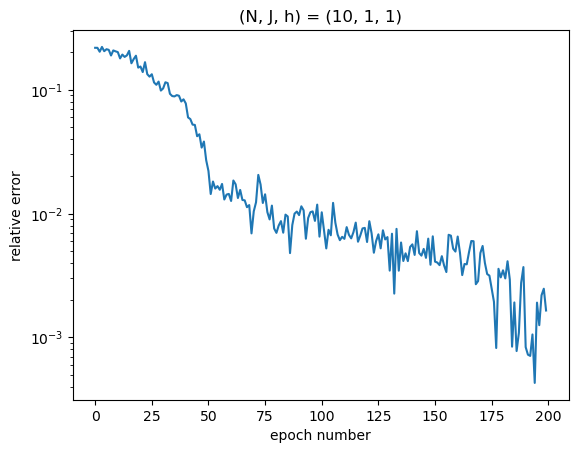

In [9]:
energy_data = np.array(energy_data)
errors = abs((energy_data - true_gse) / true_gse)
plt.plot(epochs, errors)
plt.xlabel('epoch number')
plt.yscale('log')
plt.ylabel('relative error')
plt.title(f'(N, J, h) = {N, J, h}')
plt.show()

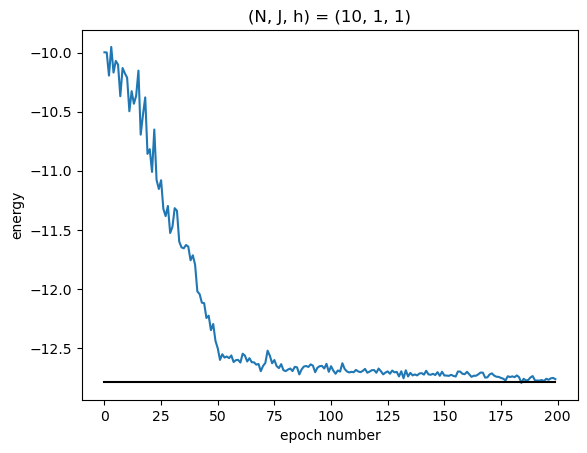

In [10]:
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs - 1], [true_gse] * 2, color = 'black')
plt.xlabel('epoch number')
plt.ylabel('energy')
plt.title(f'(N, J, h) = {N, J, h}')
plt.show()

In [31]:
model_gs = utils.log_amp_phase(kan_model(utils.generate_input_torch(N)))
model_gs = qt.Qobj(model_gs.detach().numpy().T)
print(model_gs.shape)
print(model_gs)

(1024, 1)
Quantum object: dims=[[1024], [1]], shape=(1024, 1), type='ket', dtype=Dense
Qobj data =
[[12.36093712+0.01327612j]
 [ 3.30304503+0.00438639j]
 [ 3.324265  -0.0003202j ]
 ...
 [ 4.09491396+0.00479581j]
 [ 4.04091024+0.00641426j]
 [14.44394207+0.02315373j]]


In [33]:
model_gs.norm()

32.543107905435306

In [27]:
true_gs = tfim_functions.TFIM_hamiltonian(N, 1, h).eigenstates()[1][0]

In [34]:
fidelity = qt.fidelity(qt.Qobj(model_gs), true_gs)
print(fidelity / model_gs.norm())

0.9957702655000259


In [29]:
model_gse = lib.TFIM_expectation_from_torch(kan_model(utils.generate_input_torch(N)), (N, 1, h), utils.log_amp_phase)
print(model_gse)
print(abs((model_gse - true_gse) / true_gse))

tensor(-12.7707, grad_fn=<DivBackward0>)
tensor(0.0011, grad_fn=<AbsBackward0>)


In [3]:
N, J = 20, 1
num_epochs = 100
num_samples = 1024
data_rate = 1
chains = 128

In [ ]:
h = 1
true_gse = tfim_functions.ground_state_energy(h, N)
kan_model = kan.KAN(width=[N, N, 2], device=device, seed=0, auto_save = False)
optimizer = torch.optim.Adam(kan_model.parameters(), lr = 0.01)
epochs = [n for n in range(num_epochs)]
energy_data = []
for epoch in epochs:
    mh_state = MHNeuralState(N, kan_model, utils.log_amp_phase, 'idk', torch.zeros(chains, dtype = torch.long),
                             num_samples, burnin = 10 * N, lag = N, chains = chains)
    eloc_distr = tfim_functions.generate_eloc_distr(mh_state, N, J, h, kan_model)
    eloc_list = torch.tensor([eloc_distr[x] for x in mh_state.list])
    psi = kan_model(utils.generate_input_samples(N, mh_state.list))
    log_amp = psi[:, 0]; phase = psi[:, 1]
    eloc_r = eloc_list.real; eloc_i = eloc_list.imag
    energy = eloc_r.mean()
    loss = ((eloc_r - eloc_r.mean()).detach() * log_amp + (eloc_i - eloc_i.mean()).detach() * phase).mean()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % data_rate == 0:
        energy_data.append(energy)
    if epoch % 5 == 0:
        print(f'epoch: {epoch}, energy: {energy}') # took ~100 minutes

epoch: 0, energy: -20.09736442565918
epoch: 5, energy: -20.006759643554688
epoch: 10, energy: -20.027389526367188
epoch: 15, energy: -20.450475692749023
epoch: 20, energy: -21.128787994384766
epoch: 25, energy: -21.546714782714844
epoch: 30, energy: -22.406980514526367
epoch: 35, energy: -23.389543533325195
epoch: 40, energy: -23.864593505859375
epoch: 45, energy: -23.992319107055664
epoch: 50, energy: -24.151931762695312
epoch: 55, energy: -24.195951461791992
epoch: 60, energy: -24.430307388305664
epoch: 65, energy: -24.408573150634766
epoch: 70, energy: -24.502607345581055
epoch: 75, energy: -24.5062255859375
epoch: 80, energy: -24.49938201904297
epoch: 85, energy: -24.552663803100586
epoch: 90, energy: -24.600778579711914
epoch: 95, energy: -24.70001983642578


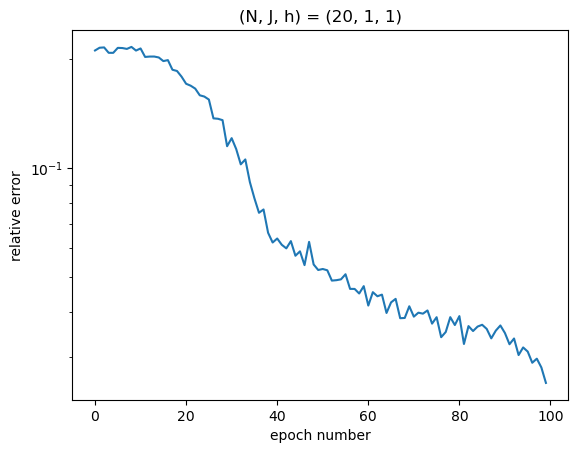

In [5]:
energy_data = np.array(energy_data)
errors = abs((energy_data - true_gse) / true_gse)
plt.plot(epochs, errors)
plt.xlabel('epoch number')
plt.yscale('log')
plt.ylabel('relative error')
plt.title(f'(N, J, h) = {N, J, h}')
plt.show()

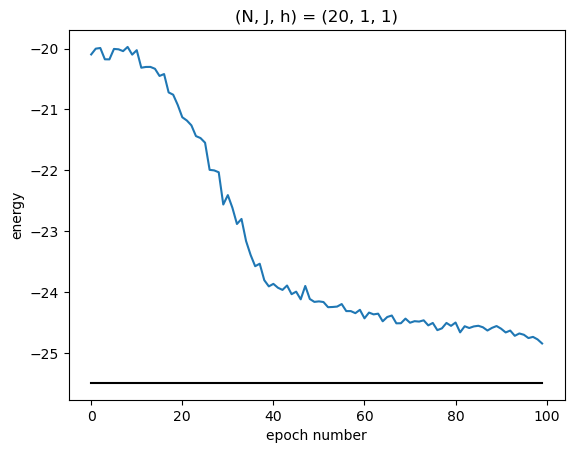

In [6]:
plt.plot(epochs, energy_data)
plt.plot([0, num_epochs - 1], [true_gse] * 2, color = 'black')
plt.xlabel('epoch number')
plt.ylabel('energy')
plt.title(f'(N, J, h) = {N, J, h}')
plt.show()

In [ ]:
model_gs = utils.log_amp_phase(kan_model(utils.generate_input_torch(N)))
model_gs = qt.Qobj(model_gs.detach().numpy().T)
print(model_gs.shape)
print(model_gs)

In [ ]:
model_gs.norm()

32.543107905435306

In [ ]:
true_gs = tfim_functions.TFIM_hamiltonian(N, 1, h).eigenstates()[1][0]

In [ ]:
fidelity = qt.fidelity(qt.Qobj(model_gs), true_gs)
print(fidelity / model_gs.norm())

0.9957702655000259


In [ ]:
model_gse = lib.TFIM_expectation_from_torch(kan_model(utils.generate_input_torch(N)), (N, 1, h), utils.log_amp_phase)
print(model_gse)
print(abs((model_gse - true_gse) / true_gse))

tensor(-12.7707, grad_fn=<DivBackward0>)
tensor(0.0011, grad_fn=<AbsBackward0>)
